**Recycling robot example** (from Sutton, page 42)
References:
  - Gym documentation: https://gym.openai.com/

  

In [86]:
import numpy as np
from gym.envs.toy_text import discrete
import random
import matplotlib.pyplot as plt
import gym
import numpy as np 
import random

# Consider the robot model described in Barto and Sutton Example 3.2

In [179]:
states = ["high", "low"]
actions = ["wait", "search", "recharge"]

P = {}

P[0] = {}
P[1] = {}

alpha = 0.5
beta = 0.4
r_wait = 0.5
r_search = 2.0

# We define a discrete environment with the corresponding transitions
def gen_ambient(alpha=alpha, beta=beta, r_wait=r_wait, r_search=r_search):
    P[0][0] = [(1.0, 0, r_wait, False)]
    P[0][1] = [(alpha, 0, r_search, False),
               (1-alpha, 1, r_search, False)]
    P[0][2] = [(1,0,0,False)]

    P[1][0] = [(1.0, 1, r_wait, False)]
    P[1][1] = [(beta, 1, r_search, False), 
               (1-beta, 0, -3.0, False)]
    P[1][2] = [(1.0, 0, 0.0, False)]
    env = discrete.DiscreteEnv(2, 3, P, [0.0, 1.0])
    return(env)
env = gen_ambient()

# Implement the random strategy for 20 steps

In [180]:
total_rewards = [0]
steps = 20 
for t in range(steps):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    total_rewards.append(reward+total_rewards[-1])
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

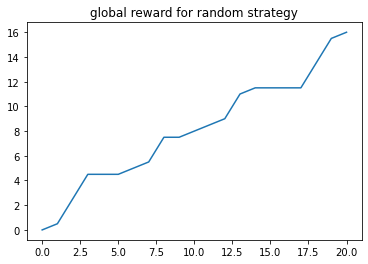

In [181]:
plt.plot(total_rewards)
_=plt.title('global reward for random strategy')

# Compute directly the optimal value function for each state


For this section and to compute directly the optimal value function , I computed the inverse of $ I - \gamma P^{\pi} $

In [182]:
def get_parameters(env_P,n_states,n_actions , action) :
    transition_mat = np.zeros((n_states,n_states))
    reward_vect = np.zeros((n_states,1))
    for state_init , vals in env_P.items() :
        for n_action,transitions in vals.items() :
            if n_action != action : 
                continue 
            for transition_tuple in transitions : 
                transition_mat[state_init , transition_tuple[1]]=transition_tuple[0]
                reward_vect[state_init] += transition_tuple[0] * transition_tuple[2]
    return reward_vect, transition_mat

In [183]:
gamma = 0.9
n_states = env.nS
n_actions = env.nA
total_values = np.zeros((n_actions,n_states))

for action in range(n_actions) : 
    reward_vect, transition_mat = get_parameters(env.P,n_states,n_actions , action)
    value_action = np.linalg.inv(np.eye(n_states) - gamma * transition_mat) @ reward_vect
    total_values[action] = value_action.squeeze()

print('Direct optimal value function is ',np.max(total_values , axis = 0))
    

Direct optimal value function is  [7.6146789 5.       ]


# Implement Value Iteration

In [73]:
def get_state_value(env_P,n_actions , n_states , gamma , state , current_value) : 
    value_actions = np.zeros((n_actions,1))
    dict_actions = env_P[state]
    for action in range(n_actions) :
        for n_action,transitions in dict_actions.items() :
            if n_action != action : 
                continue 
            for transition_tuple in transitions : 
                value_actions[action] += transition_tuple[0] * (transition_tuple[2] + \
                                                                gamma * current_value[transition_tuple[1]])
    return value_actions

In [130]:
def value_iteration(env , gamma = 0.9 , theta = 1e-8) :
    
    """
     Args:

            env: OpenAI env. env.P represents the transition probabilities of the environment.
                env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
                env.nS is a number of states in the environment. 
                env.nA is a number of actions in the environment.
            theta: We stop evaluation once our value function change is less than theta for all states.
            gamma: Gamma discount factor.

      Returns:
            Vector of length env.nS representing the value function.
    """


    n_states = env.nS
    n_actions = env.nA
    current_value = np.zeros((n_states,))
    current_policy = np.zeros((n_states,))
    delta_ = np.inf
    while delta_ > theta : 
        delta_ = 0
        for state in range(n_states) : 
            v = current_value[state]
            state_val = get_state_value(env.P,n_actions , n_states , 
                                        gamma , state , current_value)
            current_value[state] = np.max(state_val)
            current_policy[state] = np.argmax(state_val)
            delta_  = max(delta_ , np.abs(v - current_value[state]))
    return current_policy , current_value 
    


In [176]:
pi , optim_val = value_iteration(env , gamma = 0.9)
for k, (action , state_val) in enumerate(zip(pi,optim_val)) :
    print('optimal action for state {} is action {} and the optimal state value is {}'.format(k,action,
                                                                                              state_val))

optimal action for state 0 is action 1.0 and the optimal state value is 13.793103397756225
optimal action for state 1 is action 2.0 and the optimal state value is 12.413793057980602


# Implement policy iteration

In [107]:
def get_state_value_fixedpolicy (env_P, gamma , state , action,current_value) :
    transitions = env_P[state][action]
    new_state_value = 0 
    for transition_tuple in transitions : 
        new_state_value += transition_tuple[0] * (transition_tuple[2] + \
                                                        gamma * current_value[transition_tuple[1]])
    return new_state_value

In [117]:
def get_policy_evaluation(env_P , pi , theta , gamma ) :
    n_states = env.nS
    n_actions = env.nA
    current_value = np.zeros((n_states,))
    delta_ = np.inf
    while delta_ > theta : 
        delta_ = 0
        for state in range(n_states) : 
            v = current_value[state]
            current_value[state] = get_state_value_fixedpolicy(env.P,gamma , state , 
                                                               pi[state] , current_value)
            delta_  = max(delta_ , np.abs(v - current_value[state]))
    return current_value

In [171]:
def policy_improvement(env , gamma = 0.9 , theta = 1e-8) :
    """
     Args:

            env: OpenAI env. env.P represents the transition probabilities of the environment.
                env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
                env.nS is a number of states in the environment. 
                env.nA is a number of actions in the environment.
            theta: We stop evaluation once our value function change is less than theta for all states.
            gamma: Gamma discount factor.

      Returns:
            pi : vector of length env.nS representing the optimal strategy for each state. 
            current_value : Vector of length env.nS representing the value function.
    """
    stable = False
    n_states = env.nS
    n_actions = env.nA
    pi = [random.randint(0,2) for k in range(n_states)]
    current_value = np.zeros((n_states,))
    
    while not(stable) : 
        stable = True
        for state in range(n_states) : 
            old_action = pi[state]
            pi[state] = np.argmax(get_state_value(env.P,n_actions , n_states , 
                                                              gamma , state , current_value))
            if old_action != pi[state] :
                stable = False
                
        if stable == False : 
            current_value = get_policy_evaluation(env.P , pi , theta , gamma )
            
    return pi , current_value
                
        

In [175]:
pi , optim_val = policy_improvement(env , gamma = 0.9 , theta = 1e-8)
for k, (action , state_val) in enumerate(zip(pi,optim_val)) :
    print('optimal action for state {} is action {} and the optimal state value is {}'.format(k,action,
                                                                                              state_val))

optimal action for state 0 is action 1 and the optimal state value is 13.793103397756225
optimal action for state 1 is action 2 and the optimal state value is 12.413793057980602


# Using the 3 algorithms do the following experiments


In [127]:
exp1 = gen_ambient(alpha=0.9, beta=0.9, r_search=3, r_wait=2)
exp2 = gen_ambient(alpha=0.8, beta=0.5, r_search=3, r_wait=2)
exp3 = gen_ambient(alpha=0.5, beta=0.5, r_search=3, r_wait=2)
exp4 = gen_ambient(alpha=0.9, beta=0.6, r_search=1, r_wait=0.9)
exp5 = gen_ambient(alpha=0.9, beta=0.6, r_search=1, r_wait=0.5)


# Compare the different strategies with the random one

In [132]:
def get_rewards(policy , env  , gamma =0.9 ,theta = 1e-8 ) :
    total_rewards = [0]
    steps = 20 
    if policy =='policy_improvement' : 
        pi,_ = policy_improvement(env , gamma = gamma , theta = theta)
    elif policy =='value_iteration' :
        pi,_ = value_iteration(env , gamma = gamma , theta = theta)
    for t in range(steps):
        if t == 0 or policy=='random' : 
            action = env.action_space.sample()
        else : 
            action = pi[observation]
        observation, reward, done, info = env.step(action)
        total_rewards.append(reward+total_rewards[-1])
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    return total_rewards


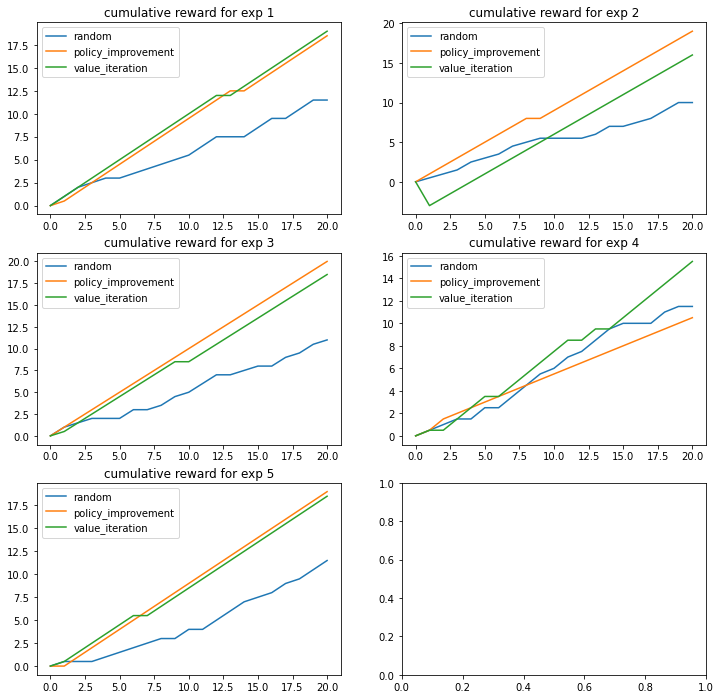

In [140]:
experiences = [exp1,exp2,exp3,exp4,exp5]
policies = ['random' , 'policy_improvement' , 'value_iteration']

fig , axis = plt.subplots(3,2 , figsize = (12,12))
for k,(exp,ax) in enumerate(zip(experiences , axis.flat)) : 
    for policy in policies : 
        total_rewards = get_rewards(policy , exp  )
        ax.plot(total_rewards , label = policy)
    ax.legend()
    ax.set_title('cumulative reward for exp {}'.format(k+1))

We can see that the total reward is better in all cases for policy improvement and value iteration compared to random strategy. 
# Compare the different strategies in terms of speed of convergence for the different scenarios

I will compare value iteration and policy improvement speed of convergence . To do this , for a given experience 
I will compute the optimal strategy and value function for 1000 times and take the time mean. 

In [168]:
import time
exp = gen_ambient(alpha=0.9, beta=0.9, r_search=3, r_wait=2)

total_time = []
tpol1 = 0
for _ in range(1000) :
    t0 = time.time()
    pi,val = policy_improvement(env , gamma = 0.9 , theta = 1e-8)
    tpol1+=time.time()-t0
total_time.append(tpol1/1000)

tpol2 = 0
for _ in range(1000) :
    t0 = time.time()
    pi,val = value_iteration(env , gamma = 0.9 , theta = 1e-8)
    tpol2+=time.time()-t0
total_time.append(tpol2/1000)

print('mean convergence time for policy improvement is {} s'.format(total_time[0]))
print('mean convergence time for value iteration is {} s'.format(total_time[1]))




mean convergence time for policy improvement is 0.0007383699417114257 s
mean convergence time for value iteration is 0.00390537428855896 s


# What would you do if alpha and beta are unknown (and you dont know RL)? Try to implement something if you have time.


If $\alpha$ and $\beta$ are unknown , a good solution to estimate them would be expectation maximization algorithm.